# Download and post-process MODIS LAI 

MODIS product:

|Product|File name|Spatial resolution|Temporal resolution|Period|
|---|---|---|---|---|
|LAI|MCD15A3H.0.61_500m_aid0001.nc|500-m|4-day|2002-07-01 - present|
|Landcover|MCD12Q1.0.61_500m_aid0001.nc|500-m|yearly|2001-01-01 - present|
|ET|MOD16A2GF.0.61_500m_aid0001.nc|500-m|8-day|2000-01-01 - present|
|Snowcover|MOD10A2.0.61_500m_aid0001.nc|500-m|6-day?|2000-02-24 - present|

In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py as h5
import geopandas as gpd
from shapely.geometry import mapping
import netCDF4 as nc
from datetime import date, datetime, timedelta
import calendar
import shutil

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [2]:
name = 'YellowStone'
fname_watershed_shp = f'../../data-processed/{name}/{name}_bounds.shp'
data_raw_dir = f'../../MODIS_raw/{name}/'
data_processed_dir = f'../../data-processed/{name}/'

fname_lai = data_raw_dir + '/MCD15A3H.061_500m_aid0001.nc'
fname_lulc = data_raw_dir + '/MCD12Q1.061_500m_aid0001.nc'
fname_et = data_raw_dir + '/MOD16A2GF.061_500m_aid0001.nc'
fname_snowcover = data_raw_dir + '/MOD10A2.061_500m_aid0001.nc'

# Import shapefile to provide the coordinates

In [3]:
watershed_shape = gpd.read_file(fname_watershed_shp)
bounds = watershed_shape.bounds

ERROR 1: PROJ: proj_create_from_database: Open of /global/homes/l/lizh142/.conda/envs/atsww/share/proj failed


In [4]:
def get_bounds(fname_watershed_shp):
    """get the min,max bounds for lat,lon for a given watershed."""
    watershed_shape = gpd.read_file(fname_watershed_shp)

    bounds = watershed_shape.bounds
    # bounds

    lonl = watershed_shape.bounds['minx'].values[0]
    lonr = watershed_shape.bounds['maxx'].values[0]
    latb = watershed_shape.bounds['miny'].values[0]
    latt = watershed_shape.bounds['maxy'].values[0]    
    
    return lonl,lonr,latb,latt

lonl,lonr,latb,latt = get_bounds(fname_watershed_shp)

lonl,lonr,latb,latt

(-799323.178093108, -779206.2167213479, 277780.672377318, 292616.5402094535)

# Use the downloaded LAI and LULC data

In [5]:
dset = xr.open_dataset(fname_lai)
dset

<xarray.Dataset> Size: 56MB
Dimensions:       (time: 2054, lat: 36, lon: 63)
Coordinates:
  * time          (time) object 16kB 2002-07-04 00:00:00 ... 2024-12-06 00:00:00
  * lat           (lat) float64 288B 44.8 44.79 44.79 ... 44.66 44.66 44.65
  * lon           (lon) float64 504B -110.6 -110.6 -110.6 ... -110.3 -110.3
Data variables:
    crs           int8 1B ...
    FparExtra_QC  (time, lat, lon) float32 19MB ...
    FparLai_QC    (time, lat, lon) float32 19MB ...
    Lai_500m      (time, lat, lon) float32 19MB ...
Attributes:
    title:        MCD15A3H.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.68
    references:   See README.md
    history:      See README.md

In [6]:
data = dset.Lai_500m
data.shape

(2054, 36, 63)

In [7]:
np.nanmin(data.values), np.nanmax(data.values)

(0.0, 7.0)

In [8]:
np.nanmean(data.values), np.nanmedian(data.values)

(0.56943876, 0.3)

# Subset data

In [10]:
mask_data = data.where((data < 10) & (data >= 0))
mask_data.min(), mask_data.max()

(<xarray.DataArray 'Lai_500m' ()> Size: 4B
 array(0., dtype=float32),
 <xarray.DataArray 'Lai_500m' ()> Size: 4B
 array(7., dtype=float32))

In [12]:
mask_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
mask_data.rio.write_crs("epsg:4326", inplace=True)
clipped_data = mask_data.rio.clip(watershed_shape.geometry.apply(mapping), watershed_shape.crs, drop = True)

In [13]:
LAI_data = clipped_data
LAI_data.shape

(2054, 34, 63)

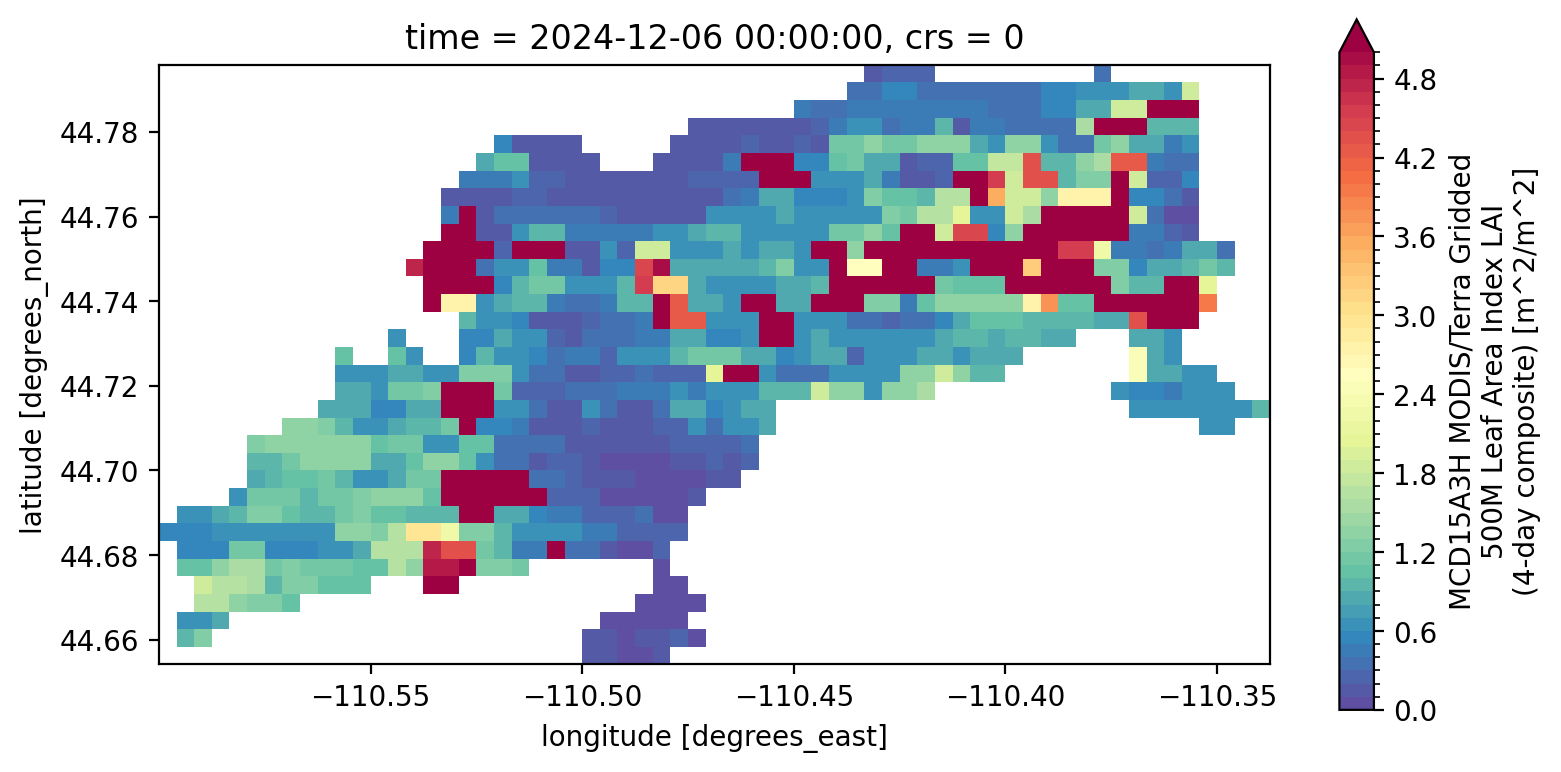

In [14]:
make_many_figs_and_gif = False
make_single_fig = True

if make_many_figs_and_gif:
    
    desktop_dir = os.environ.get('DESKTOPDIR')
    temp_imgs_dir = desktop_dir + '/LAI_temp_imgs/'

    try:
        shutil.rmtree(temp_img_dir)
    except OSError:
        pass
    os.mkdir(temp_img_dir)
    
    for i in np.arange(int(LAI_data.shape[0]/10)):
        fig, ax = plt.subplots(1, 1, figsize=(8,4))
        LAI_data.isel(time=i).plot(ax=ax, levels=np.linspace(0,5,51), cmap='Spectral_r', extend='max')
        # watershed_shape.boundary.plot(ax=ax, color='r')
        ax.set_aspect('equal')
        plt.tight_layout()
        plt.savefig(temp_img_dir + str(i).zfill(4)+'.jpg')
        plt.close()
        if i % 100 == 0:
            print(i, end=' ')
    import imageio
    from pygifsicle import optimize
    images, image_file_names = [], []
    for file_name in os.listdir(temp_img_dir):
        if file_name.endswith('.jpg'):
            image_file_names.append(file_name)       
    # sorted_files = sorted(image_file_names, key=lambda y: int(y.split('_')[1]))
    for i in range(len(image_file_names)):       
        filetemp_img_dir = os.path.join(temp_img_dir, image_file_names[i])
        images.append(imageio.imread(filetemp_img_dir))
    imageio.mimsave(desktop_dir + f'{name}_LAI.gif', images, 'GIF', loop=1, fps=30)
    optimize(desktop_dir + f'{name}_LAI.gif')
    
if make_single_fig:
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    LAI_data.isel(time=-1).plot(ax=ax, levels=np.linspace(0,5,51), cmap='Spectral_r', extend='max')
    # watershed_shape.boundary.plot(ax=ax, color='r')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


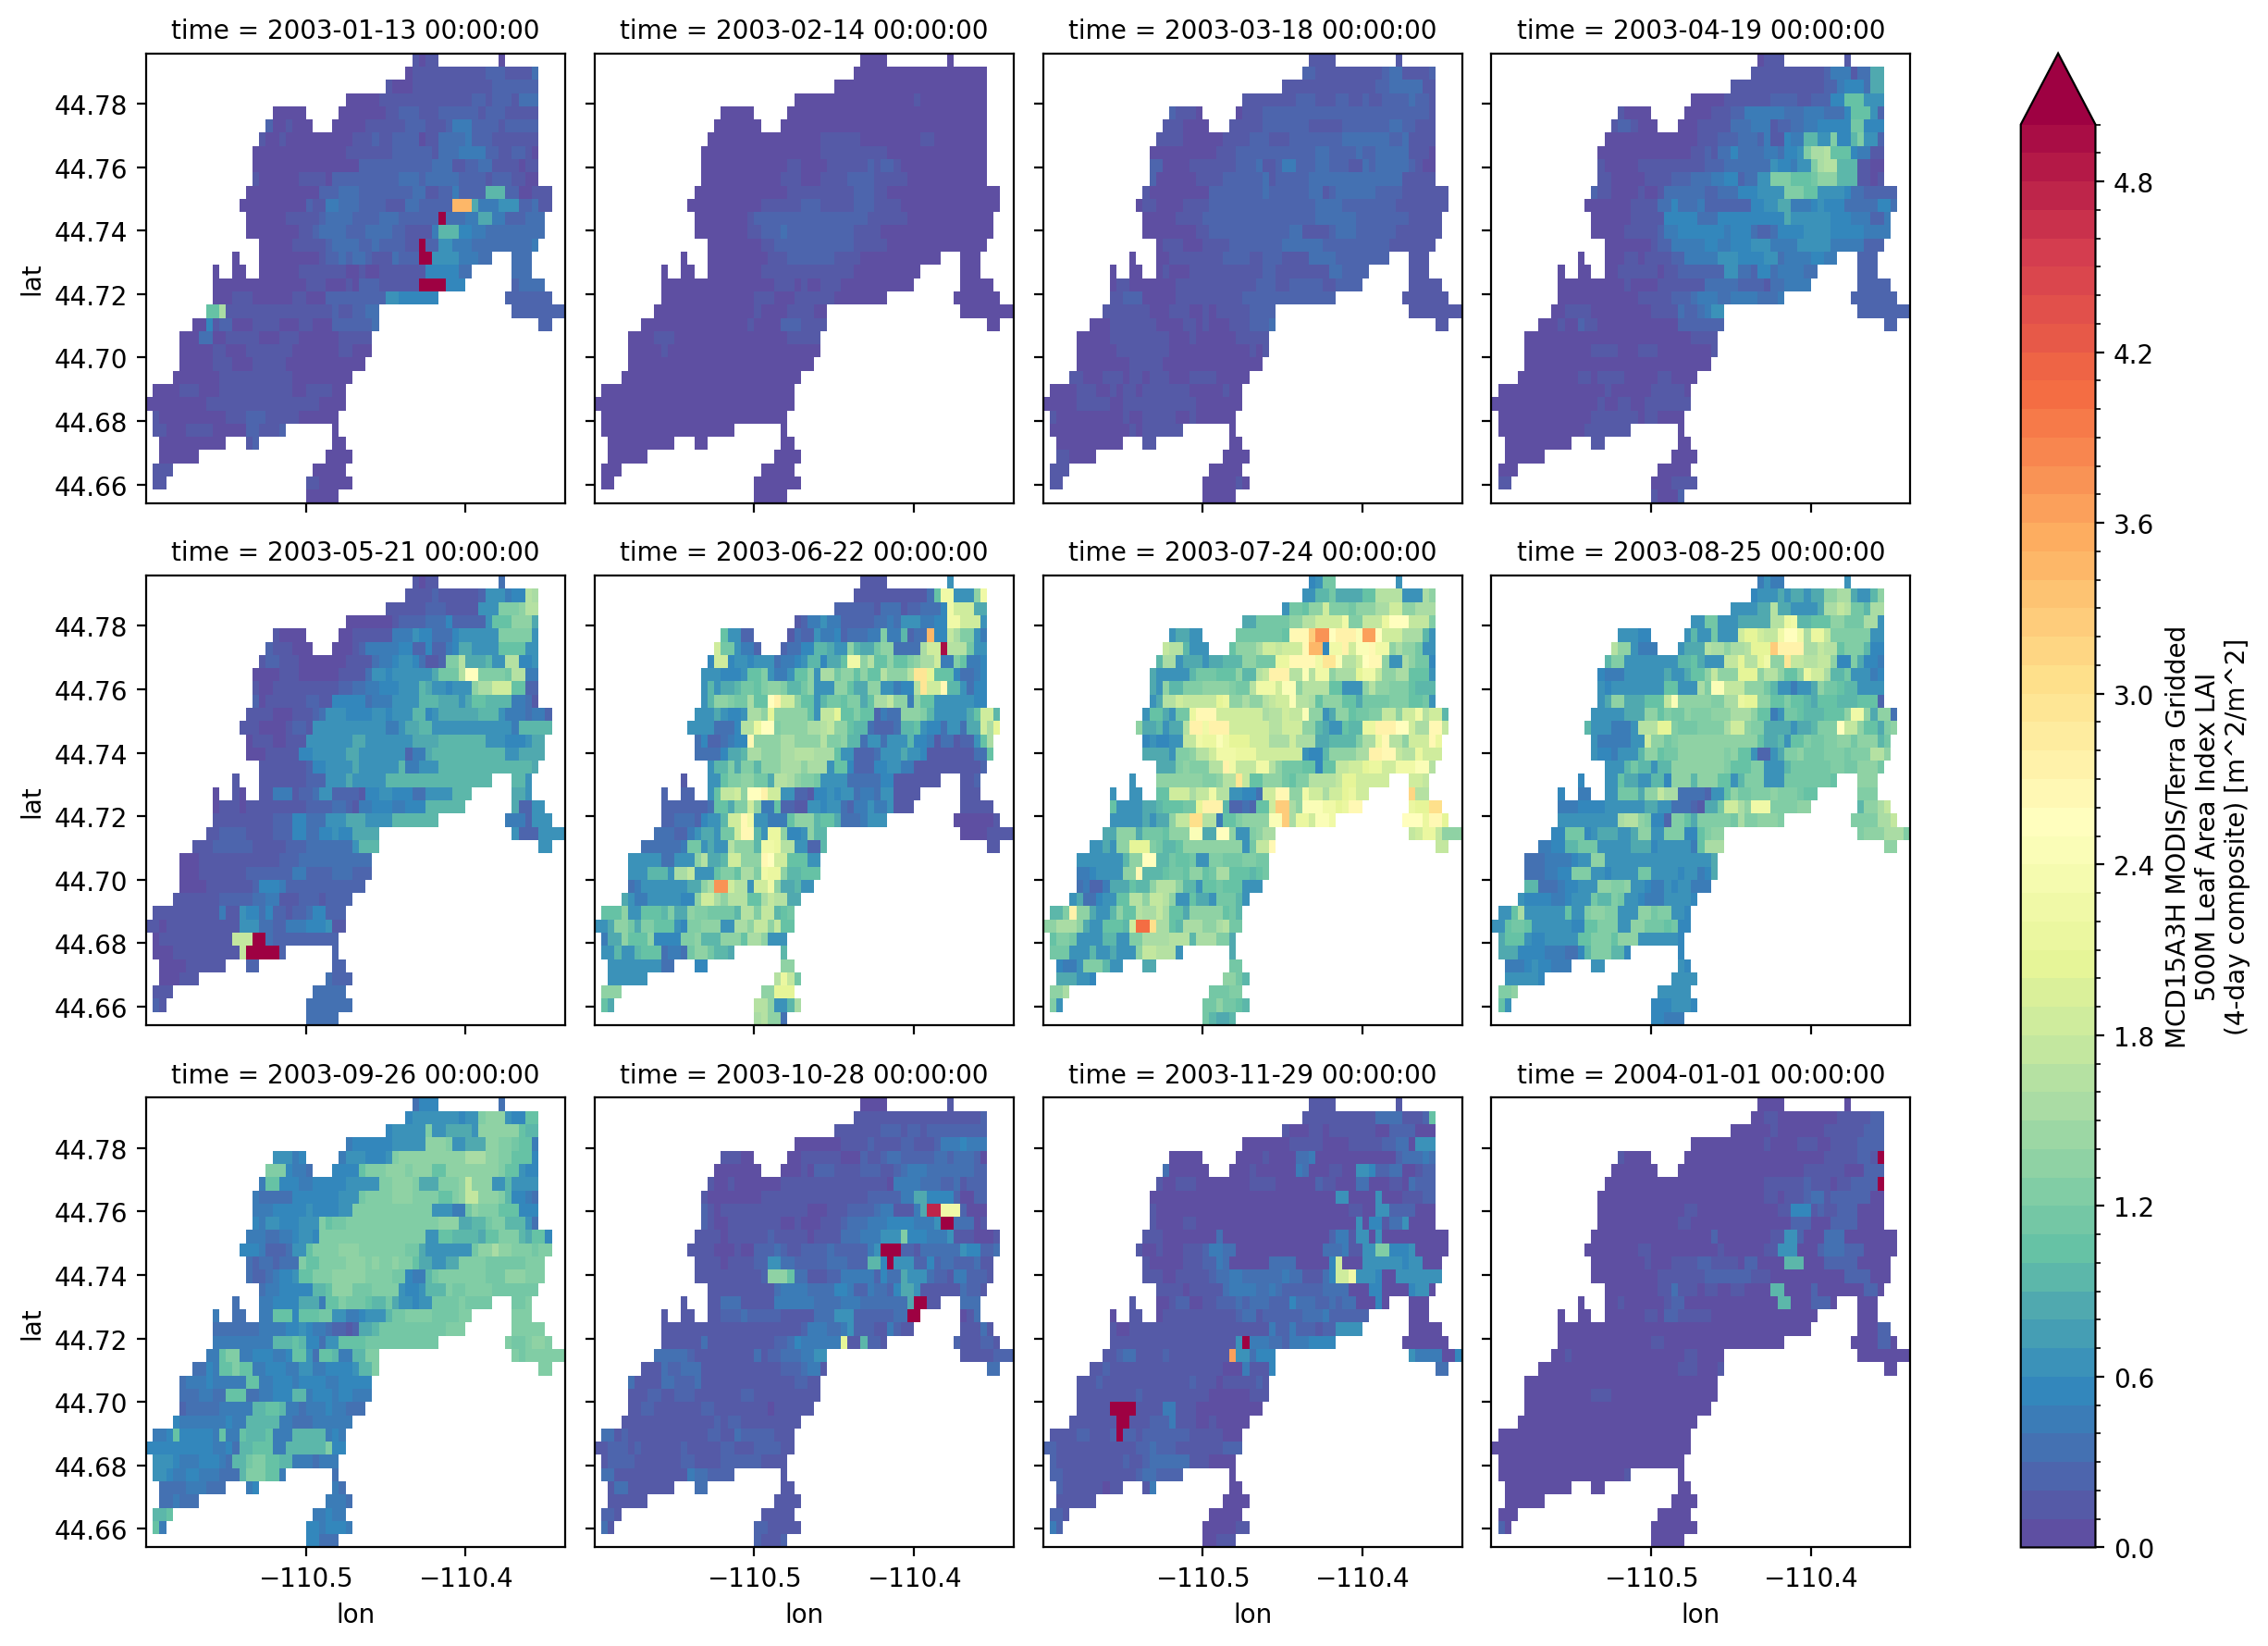

In [15]:
LAI_data.isel(time=slice(48, 137, 8)).plot(x="lon", y='lat', col="time", col_wrap=4, robust=True, levels=np.linspace(0,5,51), cmap='Spectral_r')

# LULC data

In [16]:
dset = xr.open_dataset(fname_lulc)
dset

<xarray.Dataset> Size: 418kB
Dimensions:   (time: 23, lat: 36, lon: 63)
Coordinates:
  * time      (time) object 184B 2001-01-01 00:00:00 ... 2023-01-01 00:00:00
  * lat       (lat) float64 288B 44.8 44.79 44.79 44.79 ... 44.66 44.66 44.65
  * lon       (lon) float64 504B -110.6 -110.6 -110.6 ... -110.3 -110.3 -110.3
Data variables:
    crs       int8 1B ...
    LC_Type1  (time, lat, lon) float32 209kB ...
    QC        (time, lat, lon) float32 209kB ...
Attributes:
    title:        MCD12Q1.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.68
    references:   See README.md
    history:      See README.md

In [17]:
data = dset.LC_Type1

data.shape

(23, 36, 63)

In [18]:
ids, counts = np.unique(data.values[~np.isnan(data.values)], return_counts=True)

ids, counts

(array([ 1.,  8.,  9., 10., 11., 16.], dtype=float32),
 array([ 265, 9864, 8673, 8509,   30,    6]))

In [19]:
#Colors are based on NLCD LULC colors
lc_type1_colors = {
        -1:  ('Unclassified', (0.00000000000,  0.00000000000,  0.00000000000)),
        0: ('Open Water', (0.27843137255,  0.41960784314,  0.62745098039)),
        1: ('Evergreen Needleleaf Forests', (0.10980392157,  0.38823529412,  0.18823529412)),
        2: ('Evergreen Broadleaf Forests', (0.10980392157,  0.38823529412,  0.18823529412)),
        3: ('Deciduous Needleleaf Forests', (0.40784313726,  0.66666666667,  0.38823529412)),
        4: ('Deciduous Broadleaf Forests', (0.40784313726,  0.66666666667,  0.38823529412)),
        5: ('Mixed Forests', (0.70980392157,  0.78823529412,  0.55686274510)),
        6: ('Closed Shrublands', (0.80000000000,  0.72941176471,  0.48627450980)),
        7: ('Open Shrublands', (0.80000000000,  0.72941176471,  0.48627450980)),
        # 8: ('Woody Savannas', (0.40784313726,  0.66666666667,  0.38823529412)),
        8: ('Woody Savannas', (0.60980392157,  0.68823529412,  0.55686274510)),
        9: ('Savannas', (0.70980392157,  0.78823529412,  0.55686274510)),
        10: ('Grasslands', (0.88627450980,  0.88627450980,  0.75686274510)),
        11: ('Permanent Wetlands', (0.43921568628,  0.63921568628,  0.72941176471)),
        12: ('Croplands', (0.66666666667,  0.43921568628,  0.15686274510)),
        13: ('Urban and Built up lands', (0.86666666667,  0.78823529412,  0.78823529412)),
        14: ('Cropland Natural Vegetation Mosaics', (0.66666666667,  0.43921568628,  0.15686274510)),
        15: ('Permanent Snow and Ice', (0.81960784314,  0.86666666667,  0.97647058824)),
        16: ('Barren Land', (0.69803921569,  0.67843137255,  0.63921568628)),
        17: ('Water Bodies', (0.27843137255,  0.41960784314,  0.62745098039)),
    } 


In [20]:
lc_colors = lc_type1_colors

In [21]:
colors = [lc_colors[i][1] for i in ids]

In [22]:
mask_data = data

In [23]:
mask_data.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
mask_data.rio.write_crs("epsg:4326", inplace=True)
clipped_data = mask_data.rio.clip(watershed_shape.geometry.apply(mapping), watershed_shape.crs, drop = True)

In [24]:
landcover_data = clipped_data

In [25]:
ids, counts = np.unique(clipped_data.values[~np.isnan(clipped_data.values)], return_counts=True)

colors = [lc_colors[i][1] for i in ids]

labels = [lc_colors[i][0] for i in ids]

ids, counts, colors, labels

(array([ 1.,  8.,  9., 10., 11., 16.], dtype=float32),
 array([ 259, 8885, 7925, 6769,   30,    6]),
 [(0.10980392157, 0.38823529412, 0.18823529412),
  (0.60980392157, 0.68823529412, 0.5568627451),
  (0.70980392157, 0.78823529412, 0.5568627451),
  (0.8862745098, 0.8862745098, 0.7568627451),
  (0.43921568628, 0.63921568628, 0.72941176471),
  (0.69803921569, 0.67843137255, 0.63921568628)],
 ['Evergreen Needleleaf Forests',
  'Woody Savannas',
  'Savannas',
  'Grasslands',
  'Permanent Wetlands',
  'Barren Land'])

In [26]:
ids = [0] + ids.tolist() + [11]
colors = ['grey'] + colors + ['k']
labels = ['None'] + labels + ['']

ids, counts, colors, labels

([0, 1.0, 8.0, 9.0, 10.0, 11.0, 16.0, 11],
 array([ 259, 8885, 7925, 6769,   30,    6]),
 ['grey',
  (0.10980392157, 0.38823529412, 0.18823529412),
  (0.60980392157, 0.68823529412, 0.5568627451),
  (0.70980392157, 0.78823529412, 0.5568627451),
  (0.8862745098, 0.8862745098, 0.7568627451),
  (0.43921568628, 0.63921568628, 0.72941176471),
  (0.69803921569, 0.67843137255, 0.63921568628),
  'k'],
 ['None',
  'Evergreen Needleleaf Forests',
  'Woody Savannas',
  'Savannas',
  'Grasslands',
  'Permanent Wetlands',
  'Barren Land',
  ''])

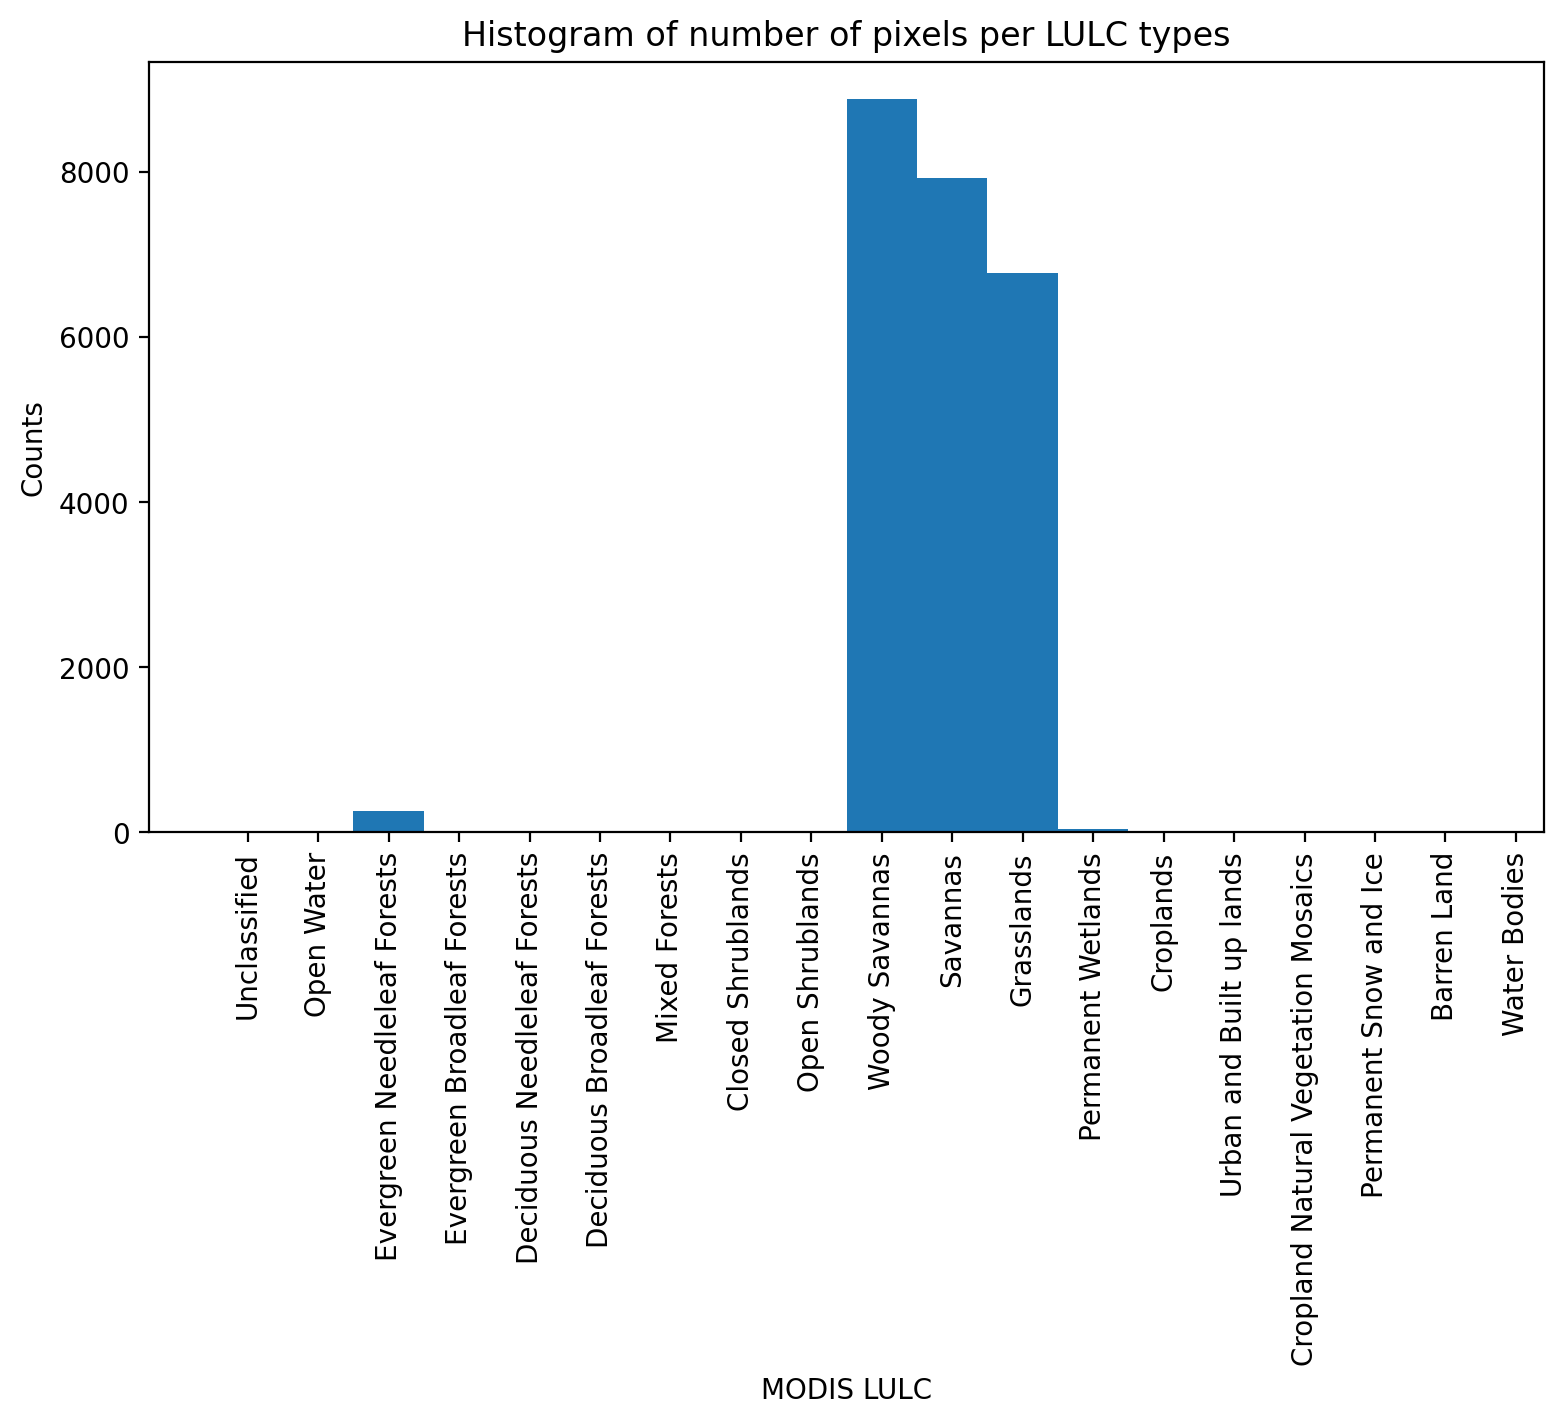

In [27]:
labelsp1 = [lc_colors[i][0] for i in lc_colors]

counts, bins = np.histogram(clipped_data, range=[-1,17], bins=18)
plt.hist(bins[:-1], bins=18, range=[-1,17], weights=counts)
plt.xlabel("MODIS LULC")
plt.ylabel("Counts")
plt.title("Histogram of number of pixels per LULC types")
plt.xticks(bins+0.5,labelsp1,rotation=90)
plt.show()

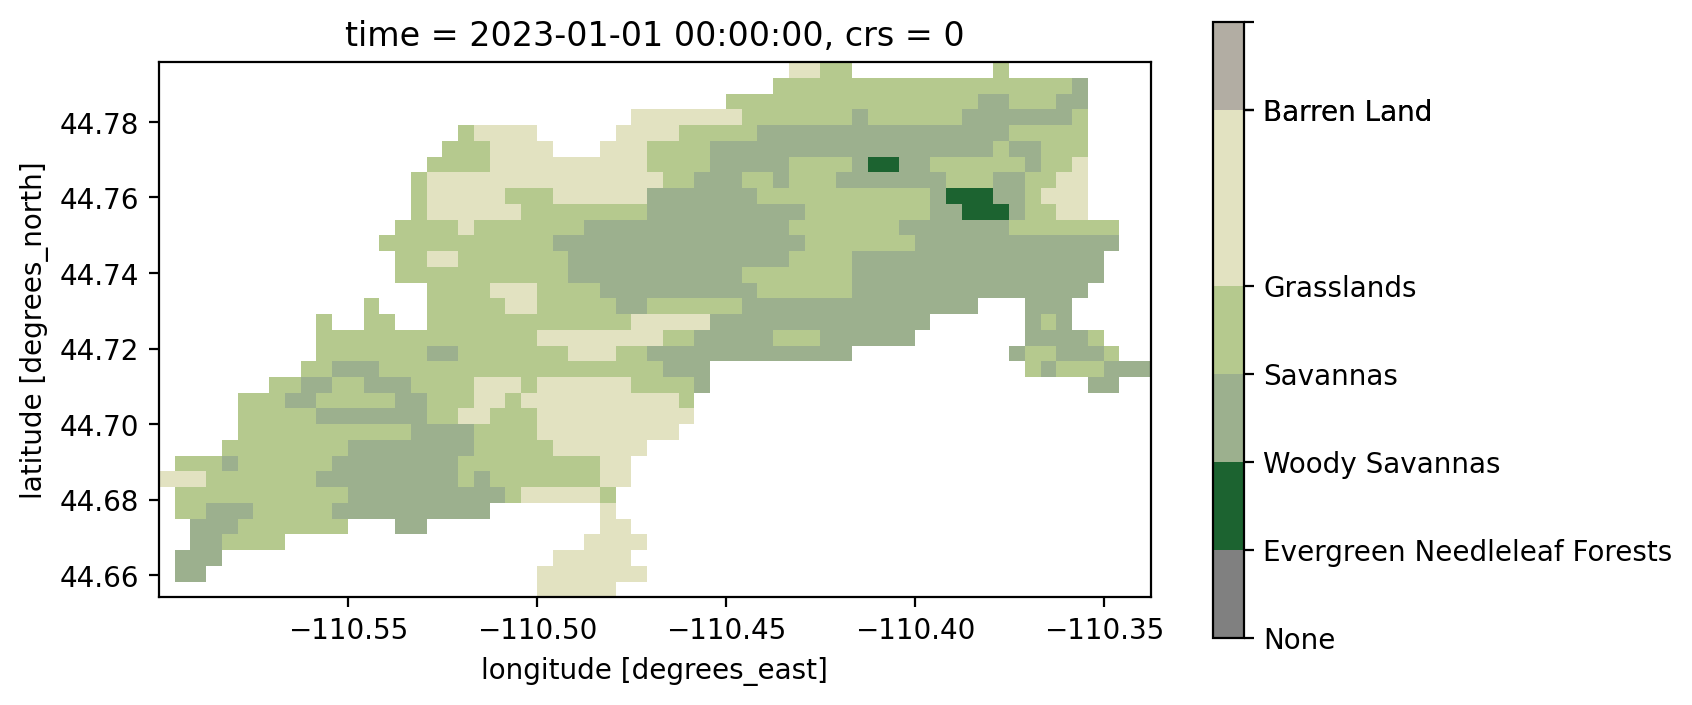

In [28]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
g = clipped_data.isel(time = -1).plot(  levels=ids, colors = colors, ax=ax, add_colorbar = False)
cb = plt.colorbar(g)
# cb.set_ticks(nlcd_ticks)
cb.set_ticklabels(labels)

watershed_shape.boundary.plot(ax=ax, color ='r')
ax.set_aspect('equal')

In [29]:
ilandcover = landcover_data.sel(time="2022-01-01").values[0,:,:]

# ilandcover.shape
lc_ids = np.unique(landcover_data.values[~np.isnan(landcover_data.values)])
print(lc_ids)
lc_labels = [lc_colors[i][0] for i in lc_ids]
print(lc_labels)
times = LAI_data.time.values
print(times)
print(len(times))

[ 1.  8.  9. 10. 11. 16.]
['Evergreen Needleleaf Forests', 'Woody Savannas', 'Savannas', 'Grasslands', 'Permanent Wetlands', 'Barren Land']
[cftime.DatetimeJulian(2002, 7, 4, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2002, 7, 8, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2002, 7, 12, 0, 0, 0, 0, has_year_zero=False) ...
 cftime.DatetimeJulian(2024, 11, 28, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2024, 12, 2, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeJulian(2024, 12, 6, 0, 0, 0, 0, has_year_zero=False)]
2054


In [30]:
LAI_lc = []

for itime in times:
#     itime = times[0]
    iCC_LAI = LAI_data.sel(time=itime).values

    iLAI_lc = []
    for i,ilabel in zip(lc_ids, lc_labels):
        idx = np.where(ilandcover == i)
        coords = list(zip(idx[0], idx[1]))
        # choose mean of the LAI for each landcover type
        iLAI = np.nanmean(np.array([iCC_LAI[i] for i in coords]))

        iLAI_lc.append(iLAI)
    
    LAI_lc.append(iLAI_lc)


/tmp/ipykernel_382184/2174517871.py:12: RuntimeWarning: Mean of empty slice
  iLAI = np.nanmean(np.array([iCC_LAI[i] for i in coords]))


In [31]:
LAI_df = pd.DataFrame(LAI_lc, columns=lc_labels)
LAI_df['datetime'] = LAI_data.indexes['time'].to_datetimeindex()
# LAI_df = LAI_df.iloc[21:-29]
LAI_df = LAI_df.iloc[21:]
LAI_df.iloc[0,-1] = LAI_df.iloc[0,-1]+(LAI_df.iloc[1,-1]-LAI_df.iloc[0,-1])/4
LAI_df.set_index('datetime', inplace=True)
LAI_df['time [s]'] = (LAI_df.index - LAI_df.index[0]).total_seconds()
LAI_df

/tmp/ipykernel_382184/3931039988.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  LAI_df['datetime'] = LAI_data.indexes['time'].to_datetimeindex()


,Evergreen Needleleaf Forests,Woody Savannas,Savannas,Grasslands,Permanent Wetlands,Barren Land,time [s]
datetime,,,,,,,
2002-10-01,0.90,0.615764,0.377725,0.2465,NaN,NaN,0.0
2002-10-04,0.53,0.660837,0.406398,0.2365,NaN,NaN,259200.0
2002-10-08,1.02,0.807636,0.532465,0.3930,NaN,NaN,604800.0
2002-10-12,0.87,0.757143,0.449526,0.2420,NaN,NaN,950400.0
2002-10-16,0.82,0.862315,0.529858,0.2845,NaN,NaN,1296000.0
...,...,...,...,...,...,...,...
2024-11-20,0.10,0.187931,0.210190,0.1145,NaN,NaN,698630400.0
2024-11-24,0.85,0.463300,0.575829,0.0670,NaN,NaN,698976000.0
2024-11-28,0.03,0.034975,0.060427,0.0245,NaN,NaN,699321600.0


(-0.5, 5.0)

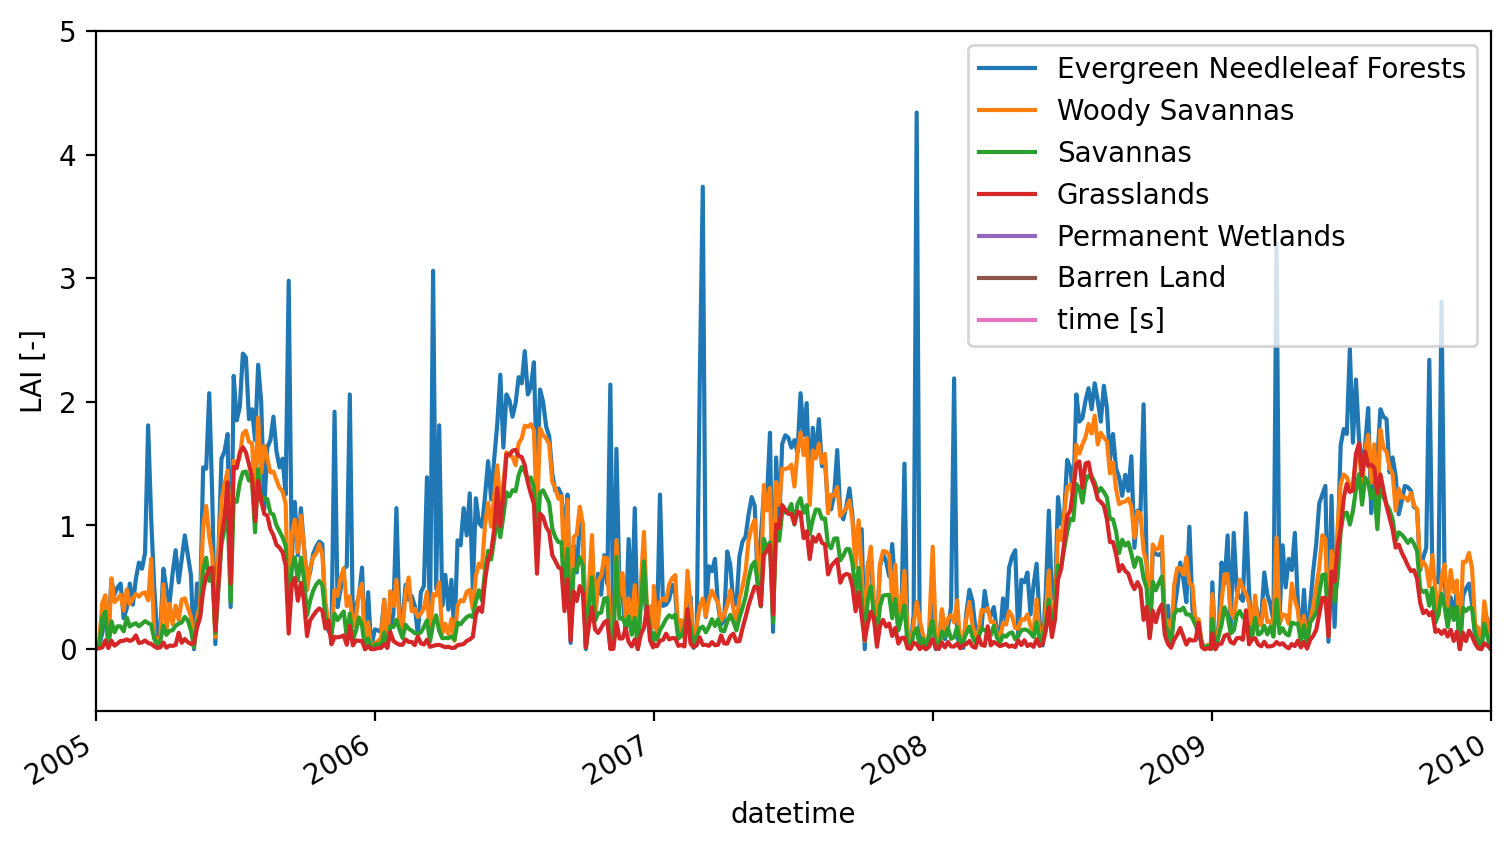

In [32]:
LAI_df.plot()
plt.ylabel('LAI [-]')
plt.xlim(["2005-01-01", "2010-01-01"])
plt.ylim(-0.5,5)

# Save raw LAI with LULC labels to hdf5

In [33]:
with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02102024_raw_LULC.h5', 'w') as fout:
    for i in LAI_df.keys():
        fout.create_dataset(i, data=LAI_df[i].values)

check keys

In [34]:
with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02102024_raw_LULC.h5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['Barren Land', 'Evergreen Needleleaf Forests', 'Grasslands', 'Permanent Wetlands', 'Savannas', 'Woody Savannas', 'time [s]']>


# Select dominant LULC types and use their LAI values for ATS run

In [45]:
cut_threshold = 0.05

In [46]:
ids, counts = np.unique(landcover_data.values[~np.isnan(landcover_data.values)], return_counts=True)

sum1 = sum(counts)
cutoff = sum1*cut_threshold #Separate LULC types with 5% of the pixel coverage cutoff
cutoff

1193.7

In [47]:
counts

array([ 259, 8885, 7925, 6769,   30,    6])

In [48]:
ids1 = np.delete(ids, np.argwhere(counts < int(cutoff)))
print(ids1)

[ 8.  9. 10.]


In [49]:
colors1 = [lc_colors[i][1] for i in ids1]
labels1 = [lc_colors[i][0] for i in ids1]

In [50]:
labels1

['Woody Savannas', 'Savannas', 'Grasslands']

In [51]:
ids1, counts = np.unique(ids1, return_counts=True)

In [52]:
countLULCclass = sum(counts)
countLULCclass

3

In [53]:
ids, counts = np.unique(landcover_data.values[~np.isnan(landcover_data.values)], return_counts=True)

if(countLULCclass >= 5):
    dom = np.argpartition(-counts, range(5))[:5]
    print(ids[dom])  # prints the 5 most frequent LULC IDs
else:
    dom = np.argpartition(-counts, range(countLULCclass))[:countLULCclass]
    print(ids[dom])  # prints the most frequent LULC ID

[ 8.  9. 10.]


In [54]:
if(countLULCclass >= 5):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC3 = a[2]
    LULC4 = a[3]
    LULC5 = a[4]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
    LULC3label = lc_colors[LULC3][0]
    LULC4label = lc_colors[LULC4][0]
    LULC5label = lc_colors[LULC5][0]
elif(countLULCclass == 4):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC3 = a[2]
    LULC4 = a[3]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
    LULC3label = lc_colors[LULC3][0]
    LULC4label = lc_colors[LULC4][0]
elif(countLULCclass == 3):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC3 = a[2]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
    LULC3label = lc_colors[LULC3][0]
elif(countLULCclass == 2):
    a = ids[dom]
    LULC1 = a[0]
    LULC2 = a[1]
    LULC1label = lc_colors[LULC1][0]
    LULC2label = lc_colors[LULC2][0]
else:
    a = ids[dom]
    LULC1 = a[0]
    LULC1label = lc_colors[LULC1][0]

# MODIS and NLCD crosswalk

<font color='green'> Users may change the crosswalk between MODIS and NLCD labels based on their study area characterisctics

In [55]:
#Colors are based on NLCD LULC colors
MODIS_labels = ['Unclassified', 
                'Open Water', 
                'Evergreen Needleleaf Forests', 
                'Evergreen Broadleaf Forests',
                'Deciduous Needleleaf Forests', 
                'Deciduous Broadleaf Forests', 
                'Mixed Forests', 
                'Closed Shrublands', 
                'Open Shrublands', 
                'Woody Savannas', 
                'Savannas', 
                'Grasslands', 
                'Permanent Wetlands', 
                'Croplands', 
                'Urban and Built up lands', 
                'Cropland Natural Vegetation Mosaics', 
                'Permanent Snow and Ice', 
                'Barren Land', 
                'Water Bodies']

In [56]:
NLCD_labels = ['None',
               'Open Water',
               'Evergreen Forest',
               'Evergreen Forest',
               'Deciduous Forest',
               'Deciduous Forest',
               'Mixed Forest',
               'Shrub/Scrub',
               'Shrub/Scrub',
               'Woody Wetlands',
               'Pasture/Hay',
               'Grassland/Herbaceous',
               'Emergent Herbaceous Wetlands',
               'Cultivated Crops',
               'Developed, Medium Intensity',
               'Cultivated Crops',
               'Perrenial Ice/Snow',
               'Barren Land',
               'Open Water']

NLCD_labels = [_lb.replace('/',' ') for _lb in NLCD_labels]
print(NLCD_labels) 

['None', 'Open Water', 'Evergreen Forest', 'Evergreen Forest', 'Deciduous Forest', 'Deciduous Forest', 'Mixed Forest', 'Shrub Scrub', 'Shrub Scrub', 'Woody Wetlands', 'Pasture Hay', 'Grassland Herbaceous', 'Emergent Herbaceous Wetlands', 'Cultivated Crops', 'Developed, Medium Intensity', 'Cultivated Crops', 'Perrenial Ice Snow', 'Barren Land', 'Open Water']


In [57]:
compare_labels = pd.DataFrame({'MODIS_labels': MODIS_labels, 'NLCD_labels': NLCD_labels})
compare_labels

,MODIS_labels,NLCD_labels
0,Unclassified,None
1,Open Water,Open Water
2,Evergreen Needleleaf Forests,Evergreen Forest
3,Evergreen Broadleaf Forests,Evergreen Forest
4,Deciduous Needleleaf Forests,Deciduous Forest
5,Deciduous Broadleaf Forests,Deciduous Forest
6,Mixed Forests,Mixed Forest
7,Closed Shrublands,Shrub Scrub
8,Open Shrublands,Shrub Scrub
9,Woody Savannas,Woody Wetlands


In [58]:
LULC1label

'Woody Savannas'

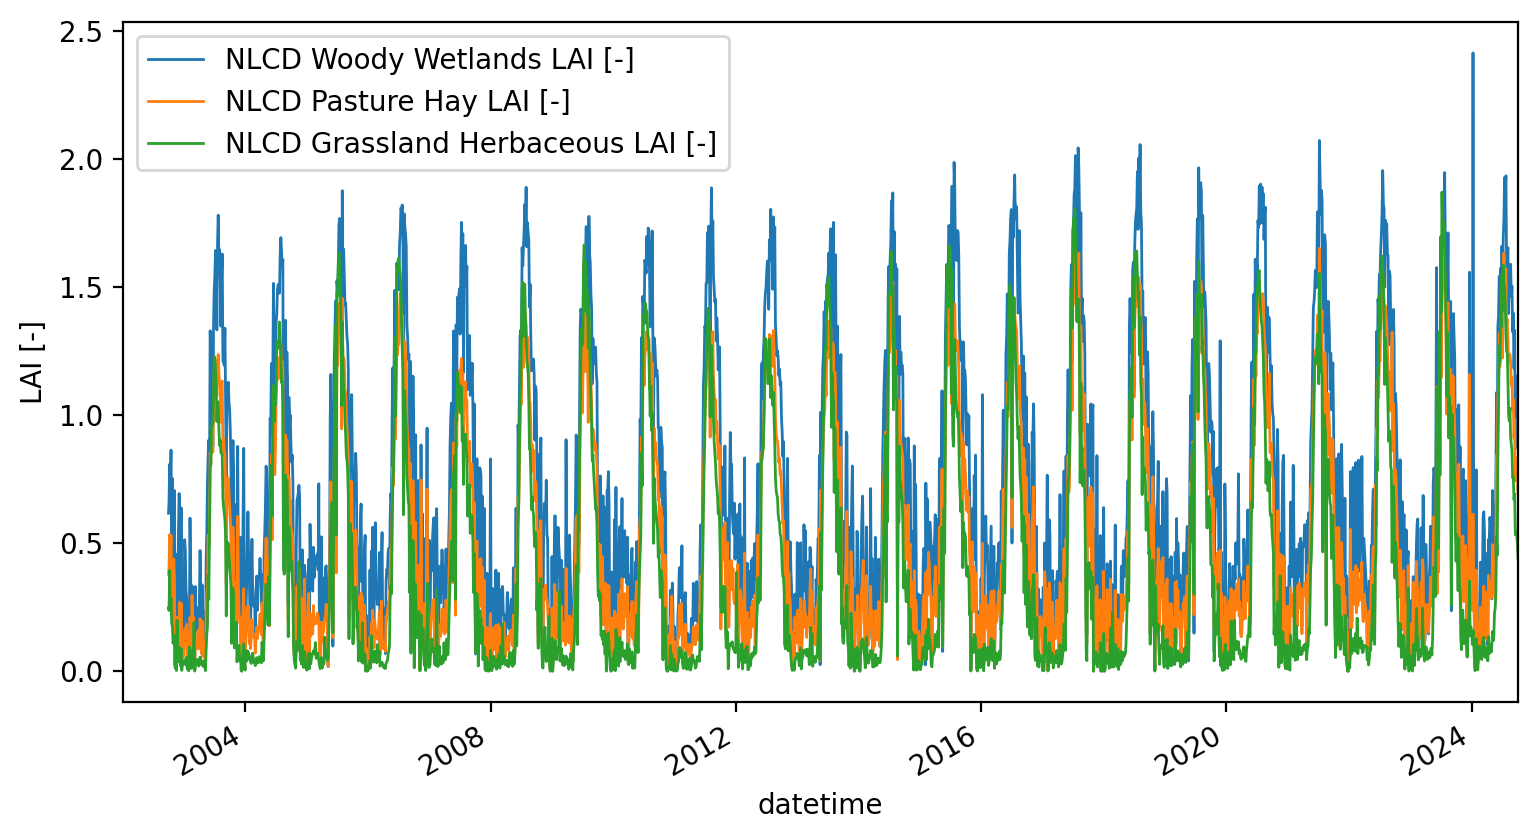

In [59]:
nlcd_LAI = LAI_df.copy()

if(countLULCclass >= 5):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    NLCDLULC3label=compare_labels[compare_labels['MODIS_labels']==LULC3label]
    NLCDLULC3label1 = NLCDLULC3label['NLCD_labels'].values[0]
    NLCDLULC4label=compare_labels[compare_labels['MODIS_labels']==LULC4label]
    NLCDLULC4label1 = NLCDLULC4label['NLCD_labels'].values[0]
    NLCDLULC5label=compare_labels[compare_labels['MODIS_labels']==LULC5label]
    NLCDLULC5label1 = NLCDLULC5label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[LULC1label]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[LULC2label]
    nlcd_LAI[f'NLCD {NLCDLULC3label1} LAI [-]'] = LAI_df[LULC3label]
    nlcd_LAI[f'NLCD {NLCDLULC4label1} LAI [-]'] = LAI_df[LULC4label]
    nlcd_LAI[f'NLCD {NLCDLULC5label1} LAI [-]'] = LAI_df[LULC5label]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]', f'NLCD {NLCDLULC5label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2002,1,1), datetime(2024,10,1))

elif(countLULCclass == 4):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    NLCDLULC3label=compare_labels[compare_labels['MODIS_labels']==LULC3label]
    NLCDLULC3label1 = NLCDLULC3label['NLCD_labels'].values[0]
    NLCDLULC4label=compare_labels[compare_labels['MODIS_labels']==LULC4label]
    NLCDLULC4label1 = NLCDLULC4label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[LULC1label]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[LULC2label]
    nlcd_LAI[f'NLCD {NLCDLULC3label1} LAI [-]'] = LAI_df[LULC3label]
    nlcd_LAI[f'NLCD {NLCDLULC4label1} LAI [-]'] = LAI_df[LULC4label]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2002,1,1), datetime(2024,10,1))

elif(countLULCclass == 3):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    NLCDLULC3label=compare_labels[compare_labels['MODIS_labels']==LULC3label]
    NLCDLULC3label1 = NLCDLULC3label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[LULC1label]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[LULC2label]
    nlcd_LAI[f'NLCD {NLCDLULC3label1} LAI [-]'] = LAI_df[LULC3label]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2002,1,1), datetime(2024,10,1))
    
elif(countLULCclass == 2):
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    NLCDLULC2label=compare_labels[compare_labels['MODIS_labels']==LULC2label]
    NLCDLULC2label1 = NLCDLULC2label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[LULC1label]
    nlcd_LAI[f'NLCD {NLCDLULC2label1} LAI [-]'] = LAI_df[LULC2label]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2002,1,1), datetime(2024,10,1))
    
else:
    NLCDLULC1label=compare_labels[compare_labels['MODIS_labels']==LULC1label]
    NLCDLULC1label1 = NLCDLULC1label['NLCD_labels'].values[0]
    
    nlcd_LAI[f'NLCD {NLCDLULC1label1} LAI [-]'] = LAI_df[LULC1label]
    
    nlcd_LAI.plot(y= [f'NLCD {NLCDLULC1label1} LAI [-]'], lw = 1)
    plt.ylabel("LAI [-]")
    plt.xlim(datetime(2002,1,1), datetime(2024,10,1))

In [60]:
nlcd_LAI

,Evergreen Needleleaf Forests,Woody Savannas,Savannas,Grasslands,Permanent Wetlands,Barren Land,time [s],NLCD Woody Wetlands LAI [-],NLCD Pasture Hay LAI [-],NLCD Grassland Herbaceous LAI [-]
datetime,,,,,,,,,,
2002-10-01,0.90,0.615764,0.377725,0.2465,NaN,NaN,0.0,0.615764,0.377725,0.2465
2002-10-04,0.53,0.660837,0.406398,0.2365,NaN,NaN,259200.0,0.660837,0.406398,0.2365
2002-10-08,1.02,0.807636,0.532465,0.3930,NaN,NaN,604800.0,0.807636,0.532465,0.3930
2002-10-12,0.87,0.757143,0.449526,0.2420,NaN,NaN,950400.0,0.757143,0.449526,0.2420
2002-10-16,0.82,0.862315,0.529858,0.2845,NaN,NaN,1296000.0,0.862315,0.529858,0.2845
...,...,...,...,...,...,...,...,...,...,...
2024-11-20,0.10,0.187931,0.210190,0.1145,NaN,NaN,698630400.0,0.187931,0.210190,0.1145
2024-11-24,0.85,0.463300,0.575829,0.0670,NaN,NaN,698976000.0,0.463300,0.575829,0.0670
2024-11-28,0.03,0.034975,0.060427,0.0245,NaN,NaN,699321600.0,0.034975,0.060427,0.0245


In [ ]:
# for t in nlcd_LAI.index:
#     if calendar.isleap(int(str(t)[:4])):
#         print(t)
#     # if np.mod((t - nlcd_LAI.index[0]).total_seconds(), 365*86400) == 0:
#     #     print(t)

# Save processed LAI with NLCD labels to hdf5

In [ ]:
# if(countLULCclass >= 5):
#     with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02022023.h5', 'w') as fout:
#         for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]', f'NLCD {NLCDLULC5label1} LAI [-]']:
#             fout.create_dataset(i, data= nlcd_LAI[i].values)
# elif(countLULCclass == 4):
#     with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02022023.h5', 'w') as fout:
#         for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]']:
#             fout.create_dataset(i, data= nlcd_LAI[i].values)
# elif(countLULCclass == 3):
#     with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02022023.h5', 'w') as fout:
#         for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]']:
#             fout.create_dataset(i, data= nlcd_LAI[i].values)
# elif(countLULCclass == 2):
#     with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02022023.h5', 'w') as fout:
#         for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]']:
#             fout.create_dataset(i, data= nlcd_LAI[i].values)
# else:
#     with h5.File(data_raw_dir + f'/{name}_MODIS_LAI_07042002_02022023.h5', 'w') as fout:
#         for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]']:
#             fout.create_dataset(i, data= nlcd_LAI[i].values)

In [ ]:
# for i in [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]']:
#     if i == f'NLCD {NLCDLULC3label1} LAI [-]':
#         a = nlcd_LAI[i].values
#         print(a)
#     if i == f'NLCD {NLCDLULC4label1} LAI [-]':
#         b = nlcd_LAI[i].values
#         print(b)

# c = (a+b)/2
# print(c)

# with h5.File(data_processed_dir + f'/{name}_MODIS_LAI_07042002_01012023.h5', 'w') as fout:
#     for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]']:
#         if i == f'NLCD {NLCDLULC3label1} LAI [-]':
#             fout.create_dataset('NLCD Shrub Scrub LAI [-]', data=c)
#         elif i == f'NLCD {NLCDLULC4label1} LAI [-]':
#             continue
#         else:
#             fout.create_dataset(i, data=nlcd_LAI[i].values)

In [ ]:
# for i in [f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]', f'NLCD {NLCDLULC4label1} LAI [-]']:
#     if i == f'NLCD {NLCDLULC3label1} LAI [-]':
#         a = nlcd_LAI[i].values
#         print(a)
#     if i == f'NLCD {NLCDLULC4label1} LAI [-]':
#         b = nlcd_LAI[i].values
#         print(b)

# c = (a+b)/2
# print(c)

with h5.File(data_processed_dir + f'/{name}_MODIS_LAI_07042002_02102024.h5', 'w') as fout:
    for i in ['time [s]', f'NLCD {NLCDLULC1label1} LAI [-]', f'NLCD {NLCDLULC2label1} LAI [-]', f'NLCD {NLCDLULC3label1} LAI [-]']:
        if i == 'NLCD Woody Wetlands LAI [-]':
            fout.create_dataset('NLCD Shrub Scrub LAI [-]', data=nlcd_LAI[i].values)
        else:
            fout.create_dataset(i, data=nlcd_LAI[i].values)

check keys

In [ ]:
with h5.File(data_processed_dir + f'/{name}_MODIS_LAI_07042002_02102024.h5') as f:
    print(f.keys())